In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gc
import re
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.utils import plot_model

seed = 1
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

from google.colab import drive
drive.mount('/content/drive')


RAW_DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data"
PROCESSED_DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/ADL/project/processed_data"
POS_DATA_DIR = os.path.join(PROCESSED_DATA_DIR, "positive")
NEG_DATA_DIR = os.path.join(PROCESSED_DATA_DIR, "negative")
MODEL_DIR = "/content/drive/MyDrive/Colab Notebooks/ADL/project/model"
RES_DIR = "/content/drive/MyDrive/Colab Notebooks/ADL/project/result"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im


def read_full_image(slide_num, level=6, ifmask=False):

  slide_name = f"Copy of tumor_{slide_num}.tif"
  tumor_mask_name = f"Copy of tumor_{slide_num}_mask.tif"

  slide_path = os.path.join(RAW_DATA_DIR, slide_name)
  tumor_mask_path = os.path.join(RAW_DATA_DIR, tumor_mask_name)

  if not ifmask:
    slide = open_slide(slide_path)
    print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                            slide.level_dimensions[level][0], 
                                                            slide.level_dimensions[level][1]))
    slide_image = read_slide(
        slide, x=0, y=0, level=level, 
        width=slide.level_dimensions[level][0], 
        height=slide.level_dimensions[level][1]) 
    
    return slide_image

  else:
    tumor_mask = open_slide(tumor_mask_path)
    print ("Read WSI from %s with width: %d, height: %d" % (tumor_mask_path, 
                                                            tumor_mask.level_dimensions[level][0], 
                                                            tumor_mask.level_dimensions[level][1]))

    mask_image = read_slide(
        tumor_mask, x=0, y=0, level=level, 
        width=tumor_mask.level_dimensions[level][0], 
        height=tumor_mask.level_dimensions[level][1])[:,:,0]

    return mask_image

# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked


In [ ]:
def get_center(slide_image, x_level, y_level, level=6, patch_len=299):
  assert 0 <= x_level + patch_len-1 <= slide_image.shape[0]
  assert 0 <= y_level + patch_len-1 <= slide_image.shape[1]
  assert 0 <= x_level <= slide_image.shape[0]
  assert 0 <= y_level <= slide_image.shape[1]

  factor = 2 ** level
  xc_level = x_level + patch_len//2
  yc_level = y_level + patch_len//2
  xc_0 = xc_level * factor
  yc_0 = yc_level * factor

  return xc_0, yc_0


def get_patch_from_center(slide_image, xc_0, yc_0, level=6, patch_len=299):
  factor = 2 ** level
  xc_level = xc_0 // factor
  yc_level = yc_0 // factor
  x_level = xc_level - patch_len//2
  y_level = yc_level - patch_len//2
  
  assert 0 <= x_level + patch_len-1 <= slide_image.shape[0]
  assert 0 <= y_level + patch_len-1 <= slide_image.shape[1]
  assert 0 <= x_level <= slide_image.shape[0]
  assert 0 <= y_level <= slide_image.shape[1]

  return slide_image[
        x_level: x_level + patch_len, y_level: y_level + patch_len]
        

def delete_gray(slide_image, threshold=0.4, show=False):
  tissue_pixels = find_tissue_pixels(slide_image)
  percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
  if show:
    print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 
  
  if percent_tissue >= threshold:
    return True
  else:
    return False

def get_target(mask_region, patch_len=299, target_size=128):
  offset = (patch_len - target_size)//2
  target = mask_region[offset: offset+128, offset: offset+128]
  return 1.0 if target.sum() != 0 else 0.0

In [ ]:
def get_patches_from_center(multi_slide_images, xc_0, yc_0, level_lst=[5,6,7], patch_len=299):
  multi_pitches = []
  for i, level in enumerate(level_lst):
    factor = 2 ** level
    xc_level = xc_0 // factor
    yc_level = yc_0 // factor

    x_level = xc_level - patch_len//2
    y_level = yc_level - patch_len//2

    slide_image = multi_slide_images[i]
    assert 0 <= x_level + patch_len-1 <= slide_image.shape[0]
    assert 0 <= y_level + patch_len-1 <= slide_image.shape[1]
    assert 0 <= x_level <= slide_image.shape[0]
    assert 0 <= y_level <= slide_image.shape[1]

    multi_pitches.append(slide_image[
        x_level: x_level + patch_len, y_level: y_level + patch_len])
    
  return multi_pitches

In [ ]:
def allocate_ones(mask_image, patch_len=299):
  # Allocate ones
  allocated_ones = np.where(mask_image == 1)
  all_ones = list(zip(allocated_ones[0], allocated_ones[1]))
  print("The number of tumor pixels", len(all_ones))

  all_ones = [
      (x, y) for x, y in all_ones if (
          patch_len//2 < x < slide_image.shape[0]-patch_len//2) and (
              patch_len//2 < y < slide_image.shape[1]-patch_len//2)]
  random.shuffle(all_ones)
  print("The number of tumor pixels after filter", len(all_ones))
  return all_ones


def allocate_zeros(slide_image, mask_image, patch_len=299):
  tissue_pixels = find_tissue_pixels(slide_image)
  tissue_pixels = set(tissue_pixels)
  print("The number of tissue", len(tissue_pixels))

  allocated_ones = np.where(mask_image == 1)
  all_ones = list(zip(allocated_ones[0], allocated_ones[1]))
  all_ones = set(all_ones)
  print("The number of tumor", len(all_ones))

  tissue_pixels = list(tissue_pixels.difference(all_ones))
  print("The number of normal tissue", len(tissue_pixels))

  tissue_pixels = [
      (x, y) for x, y in tissue_pixels if (
          patch_len//2 < x < slide_image.shape[0]-patch_len//2) and (
              patch_len//2 < y < slide_image.shape[1]-patch_len//2)]
  random.shuffle(tissue_pixels)
  print("The number of normal tissue after filter", len(tissue_pixels))
  return tissue_pixels

In [ ]:
# ["091", "101", "110", "016", "078", "031", "064"]

In [ ]:
# file_name_lst = list(set(map(lambda x: re.findall(r'\d+', x)[0], os.listdir(RAW_DATA_DIR))))

# for slide_num in file_name_lst:
#   mask_image = read_full_image(slide_num, level=7, ifmask=True)
#   print("Total tumor area", mask_image.sum())
#   print("\n")

In [ ]:
patch_len = 299

inception_zoom1 = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(patch_len, patch_len, 3))

inception_zoom2 = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(patch_len, patch_len, 3))

inception_zoom3 = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(patch_len, patch_len, 3))

# freeze the inception model to increase training speed
inception_zoom1.trainable = False
inception_zoom2.trainable = False
inception_zoom3.trainable = False

# creat the base model
model_zoom1 = models.Sequential()
model_zoom1.add(inception_zoom1)
model_zoom1.add(layers.GlobalAveragePooling2D())

model_zoom2 = models.Sequential()
model_zoom2.add(inception_zoom2)
model_zoom2.add(layers.GlobalAveragePooling2D())

model_zoom3 = models.Sequential()
model_zoom3.add(inception_zoom3)
model_zoom3.add(layers.GlobalAveragePooling2D())

input_zoom1 = layers.Input(shape=(patch_len, patch_len, 3), name="input1")
input_zoom2 = layers.Input(shape=(patch_len, patch_len, 3), name="input2")
input_zoom3 = layers.Input(shape=(patch_len, patch_len, 3), name="input3")

encoded_zoom1 = model_zoom1(input_zoom1)
encoded_zoom2 = model_zoom2(input_zoom2)
encoded_zoom3 = model_zoom3(input_zoom3)

merged = layers.concatenate([encoded_zoom1, encoded_zoom2, encoded_zoom3])
dense1 = layers.Dense(256, activation='relu')(merged)
drop_layer = layers.Dropout(0.5)(dense1)
dense2 = layers.Dense(126, activation='relu')(drop_layer)

output = layers.Dense(1, activation='sigmoid')(dense2)
model = models.Model(inputs=[input_zoom1, input_zoom2, input_zoom3], outputs=output)

model.summary()

model.compile(loss=losses.BinaryCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.5))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 input2 (InputLayer)            [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 input3 (InputLayer)            [(None, 299, 299, 3  0           []                               
                                )]                                                            

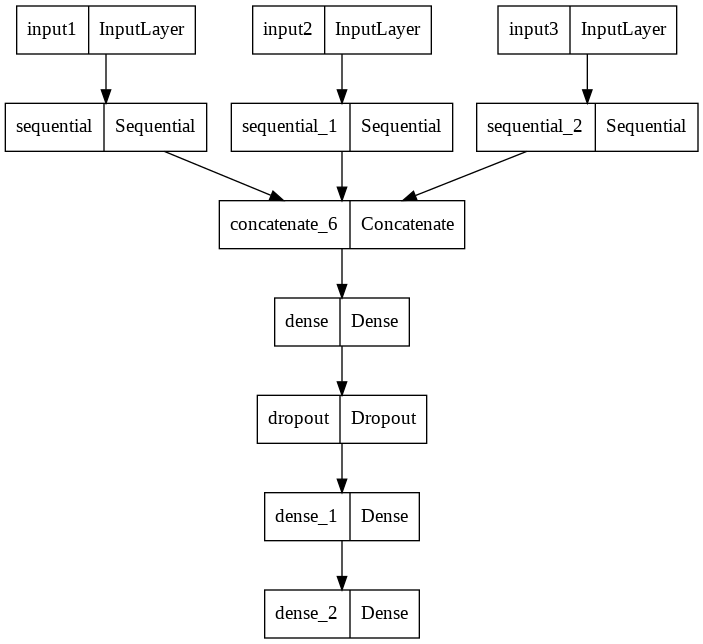

In [ ]:
base_model_structure = os.path.join(MODEL_DIR, 'model_threezooms_567.png')
plot_model(model, to_file=base_model_structure)

In [ ]:
train_file = ["101", "094", "110", "016", "078", "031", "064"]
test_file = ["091", "075", "094", "084"]

In [ ]:
sampling_times = 10
nsamples = 200
level_lst = [5, 6, 7]
val_split = 0.3

In [ ]:
train_loss_lst = []
train_accuracy_lst = []
val_loss_lst = []
val_accuracy_lst = []

In [ ]:
for s_i in range(sampling_times):

  for slide_num in train_file:
    print("\nStart Processing for", slide_num)
    multi_slide_images = []
    multi_mask_images = []
    for level in level_lst:
      slide_image = read_full_image(slide_num, level=level, ifmask=False)
      mask_image = read_full_image(slide_num, level=level, ifmask=True)
      multi_slide_images.append(slide_image)
      multi_mask_images.append(mask_image)

    all_ones = allocate_ones(multi_mask_images[-1])
    all_zeros = allocate_zeros(multi_slide_images[-1], multi_mask_images[-1])

    # Generate samples and train model
    neg_i = 0
    factor = 2 ** level_lst[-1]

    print("Sampling", s_i)
    start_ind = s_i * nsamples
    end_ind = (s_i+1) * nsamples

    if end_ind <= len(all_ones):

      # positive samples
      print("Generating positive samples......")
      pos_file = os.path.join(POS_DATA_DIR, f"{slide_num}_567_{s_i}.npy")

      if not os.path.exists(pos_file):
        print("------Process samples-------")
        selected_centers = all_ones[start_ind: end_ind]

        pos_pitch_lst = [[] for _ in range(len(level_lst))]
        for x_cen, y_cen in selected_centers:
          multi_check_images = get_patches_from_center(multi_mask_images, x_cen*factor, y_cen*factor, level_lst=level_lst)
          multi_tumor_regions = get_patches_from_center(multi_slide_images, x_cen*factor, y_cen*factor, level_lst=level_lst)
          assert multi_check_images[0].sum() != 0
          assert get_target(multi_check_images[0]) == 1.0

          for i in range(len(level_lst)):
            pos_pitch_lst[i].append(multi_tumor_regions[i] / 255.0)

        pos_pitch_lst = np.array(pos_pitch_lst)
        np.save(pos_file, pos_pitch_lst)

      else:
        print("------Load samples-------")
        pos_pitch_lst = np.load(pos_file)

      train_dataset = tf.data.Dataset.from_tensor_slices(
          ({'input1': np.array(pos_pitch_lst[0][int(val_split*nsamples) :]), 
            'input2': np.array(pos_pitch_lst[1][int(val_split*nsamples) :]),
            'input3': np.array(pos_pitch_lst[2][int(val_split*nsamples) :])}, 
          np.array([1.0] * nsamples)[int(val_split*nsamples) :])
          )

      val_dataset = tf.data.Dataset.from_tensor_slices(
          ({'input1': np.array(pos_pitch_lst[0][: int(val_split*nsamples)]), 
            'input2': np.array(pos_pitch_lst[1][: int(val_split*nsamples)]),
            'input3': np.array(pos_pitch_lst[2][: int(val_split*nsamples)])}, 
          np.array([1.0] * nsamples)[: int(val_split*nsamples)])
          )
      del pos_pitch_lst
      gc.collect()
      

      # negative samples
      print("Generating negative samples......")
      neg_file = os.path.join(NEG_DATA_DIR, f"{slide_num}_567_{s_i}.npy")

      if not os.path.exists(neg_file):
        print("------Process samples-------")
        neg_pitch_lst = [[] for _ in range(len(level_lst))]

        while len(neg_pitch_lst[0]) < nsamples:
          x_cen, y_cen = all_zeros[neg_i]

          multi_tumor_regions = get_patches_from_center(multi_slide_images, x_cen*factor, y_cen*factor, level_lst=level_lst)

          # Make sure that minimum zoom level have enough tissue
          if delete_gray(multi_tumor_regions[0]):
            multi_check_images = get_patches_from_center(multi_mask_images, x_cen*factor, y_cen*factor, level_lst=level_lst)

            # Make sure that minimum zoom level have tumor
            label = get_target(multi_check_images[0])
            if label == 0.0:
              for i in range(len(level_lst)):
                neg_pitch_lst[i].append(multi_tumor_regions[i] / 255.0)
          neg_i += 1

        neg_pitch_lst = np.array(neg_pitch_lst)
        np.save(neg_file, neg_pitch_lst)

      else:
        print("------Load samples-------")
        neg_pitch_lst = np.load(neg_file)
      
      train_dataset = train_dataset.concatenate(
          tf.data.Dataset.from_tensor_slices(
              ({'input1': np.array(neg_pitch_lst[0][int(val_split*nsamples) :]), 
                'input2': np.array(neg_pitch_lst[1][int(val_split*nsamples) :]),
                'input3': np.array(neg_pitch_lst[2][int(val_split*nsamples) :])}, 
              np.array([0.0] * nsamples)[int(val_split*nsamples) :])
              )
            )
      
      val_dataset = val_dataset.concatenate(
          tf.data.Dataset.from_tensor_slices(
              ({'input1': np.array(neg_pitch_lst[0][: int(val_split*nsamples)]), 
                'input2': np.array(neg_pitch_lst[1][: int(val_split*nsamples)]),
                'input3': np.array(neg_pitch_lst[2][: int(val_split*nsamples)])}, 
            np.array([0.0] * nsamples)[: int(val_split*nsamples)])
              )
          )
      del neg_pitch_lst
      gc.collect()

      # Prepare dataset
      print("Prepare dataset......")
      BATCH_SIZE = 64
      SHUFFLE_BUFFER_SIZE = int(nsamples*2*(1-val_split))
      train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
      
      BATCH_SIZE = 64
      SHUFFLE_BUFFER_SIZE = int(nsamples*2*val_split)
      val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

      print("Train model......")
      checkpoint_path = os.path.join(MODEL_DIR, "model_567_200.ckpt")
      cp_callback = tf.keras.callbacks.ModelCheckpoint(
          filepath=checkpoint_path, save_weights_only=True, verbose=1)
      
      history = model.fit(train_dataset, validation_data=val_dataset, epochs=2, callbacks=[cp_callback])

      train_loss_lst.extend(history.history["loss"])
      train_accuracy_lst.extend(history.history["binary_accuracy"])
      val_loss_lst.extend(history.history["val_loss"])
      val_accuracy_lst.extend(history.history["val_binary_accuracy"])

      res_df = pd.DataFrame({
          "train_loss_lst": train_loss_lst,
          "train_accuracy_lst": train_accuracy_lst,
          "val_loss_lst": val_loss_lst,
          "val_accuracy_lst": val_accuracy_lst
      })
      res_file = os.path.join(RES_DIR, "res_567_200.csv")
      res_df.to_csv(res_file, index=False)




Start Processing for 101
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_101.tif with width: 4352, height: 2240
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_101_mask.tif with width: 4352, height: 2240
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_101.tif with width: 2176, height: 1120
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_101_mask.tif with width: 2176, height: 1120
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_101.tif with width: 1088, height: 560
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_101_mask.tif with width: 1088, height: 560
The number of tumor pixels 11756
The number of tumor pixels after filter 6350
The number of tissue 150818
The number of tumor 11756
The number of normal tissue 139078
The number of normal tissue afte

In [ ]:
# for slide_num in train_file:
#   print("\nStart Processing for", slide_num)
#   multi_slide_images = []
#   multi_mask_images = []
#   for level in level_lst:
#     slide_image = read_full_image(slide_num, level=level, ifmask=False)
#     mask_image = read_full_image(slide_num, level=level, ifmask=True)
#     multi_slide_images.append(slide_image)
#     multi_mask_images.append(mask_image)

#   all_ones = allocate_ones(multi_mask_images[-1])
#   all_zeros = allocate_zeros(multi_slide_images[-1], multi_mask_images[-1])

#   # Generate samples and train model
#   neg_i = 0
#   factor = 2 ** level_lst[-1]

#   for s_i in range(sampling_times):
#     print("Sampling", s_i)
#     start_ind = s_i * nsamples
#     end_ind = (s_i+1) * nsamples

#     if end_ind <= len(all_ones):

#       # positive samples
#       print("Generating positive samples......")
#       pos_file = os.path.join(POS_DATA_DIR, f"{slide_num}_567_{s_i}.npy")

#       if not os.path.exists(pos_file):
#         print("------Process samples-------")
#         selected_centers = all_ones[start_ind: end_ind]

#         pos_pitch_lst = [[] for _ in range(len(level_lst))]
#         for x_cen, y_cen in selected_centers:
#           multi_check_images = get_patches_from_center(multi_mask_images, x_cen*factor, y_cen*factor, level_lst=level_lst)
#           multi_tumor_regions = get_patches_from_center(multi_slide_images, x_cen*factor, y_cen*factor, level_lst=level_lst)
#           assert multi_check_images[0].sum() != 0
#           assert get_target(multi_check_images[0]) == 1.0

#           for i in range(len(level_lst)):
#             pos_pitch_lst[i].append(multi_tumor_regions[i] / 255.0)

#         pos_pitch_lst = np.array(pos_pitch_lst)
#         np.save(pos_file, pos_pitch_lst)

#       else:
#         print("------Load samples-------")
#         pos_pitch_lst = np.load(pos_file)

#       train_dataset = tf.data.Dataset.from_tensor_slices(
#           ({'input1': np.array(pos_pitch_lst[0][int(val_split*nsamples) :]), 
#             'input2': np.array(pos_pitch_lst[1][int(val_split*nsamples) :]),
#             'input3': np.array(pos_pitch_lst[2][int(val_split*nsamples) :])}, 
#           np.array([1.0] * nsamples)[int(val_split*nsamples) :])
#           )

#       val_dataset = tf.data.Dataset.from_tensor_slices(
#           ({'input1': np.array(pos_pitch_lst[0][: int(val_split*nsamples)]), 
#             'input2': np.array(pos_pitch_lst[1][: int(val_split*nsamples)]),
#             'input3': np.array(pos_pitch_lst[2][: int(val_split*nsamples)])}, 
#           np.array([1.0] * nsamples)[: int(val_split*nsamples)])
#           )
#       del pos_pitch_lst
#       gc.collect()
      

#       # negative samples
#       print("Generating negative samples......")
#       neg_file = os.path.join(NEG_DATA_DIR, f"{slide_num}_567_{s_i}.npy")

#       if not os.path.exists(neg_file):
#         print("------Process samples-------")
#         neg_pitch_lst = [[] for _ in range(len(level_lst))]

#         while len(neg_pitch_lst[0]) < nsamples:
#           x_cen, y_cen = all_zeros[neg_i]

#           multi_tumor_regions = get_patches_from_center(multi_slide_images, x_cen*factor, y_cen*factor, level_lst=level_lst)

#           # Make sure that minimum zoom level have enough tissue
#           if delete_gray(multi_tumor_regions[0]):
#             multi_check_images = get_patches_from_center(multi_mask_images, x_cen*factor, y_cen*factor, level_lst=level_lst)

#             # Make sure that minimum zoom level have tumor
#             label = get_target(multi_check_images[0])
#             if label == 0.0:
#               for i in range(len(level_lst)):
#                 neg_pitch_lst[i].append(multi_tumor_regions[i] / 255.0)
#           neg_i += 1

#         neg_pitch_lst = np.array(neg_pitch_lst)
#         np.save(neg_file, neg_pitch_lst)

#       else:
#         print("------Load samples-------")
#         neg_pitch_lst = np.load(neg_file)
      
#       train_dataset = train_dataset.concatenate(
#           tf.data.Dataset.from_tensor_slices(
#               ({'input1': np.array(neg_pitch_lst[0][int(val_split*nsamples) :]), 
#                 'input2': np.array(neg_pitch_lst[1][int(val_split*nsamples) :]),
#                 'input3': np.array(neg_pitch_lst[2][int(val_split*nsamples) :])}, 
#               np.array([0.0] * nsamples)[int(val_split*nsamples) :])
#               )
#           )
      
#       val_dataset = val_dataset.concatenate(
#           tf.data.Dataset.from_tensor_slices(
#               ({'input1': np.array(neg_pitch_lst[0][: int(val_split*nsamples)]), 
#                 'input2': np.array(neg_pitch_lst[1][: int(val_split*nsamples)]),
#                 'input3': np.array(neg_pitch_lst[2][: int(val_split*nsamples)])}, 
#             np.array([0.0] * nsamples)[: int(val_split*nsamples)])
#               )
#           )
#       del neg_pitch_lst
#       gc.collect()

#       # Prepare dataset
#       print("Prepare dataset......")
#       BATCH_SIZE = 64
#       SHUFFLE_BUFFER_SIZE = int(nsamples*2*(1-val_split))
#       train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
      
#       BATCH_SIZE = 64
#       SHUFFLE_BUFFER_SIZE = int(nsamples*2*val_split)
#       val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

#       print("Train model......")
#       checkpoint_path = os.path.join(MODEL_DIR, "model_567_200.ckpt")
#       cp_callback = tf.keras.callbacks.ModelCheckpoint(
#           filepath=checkpoint_path, save_weights_only=True, verbose=1)
      
#       history = model.fit(train_dataset, validation_data=val_dataset, epochs=2, callbacks=[cp_callback])
#       his_lst.append(history)

#       train_loss_lst.extend(history.history["loss"])
#       train_accuracy_lst.extend(history.history["binary_accuracy"])
#       val_loss_lst.extend(history.history["val_loss"])
#       val_accuracy_lst.extend(history.history["val_binary_accuracy"])

#       res_df = pd.DataFrame({
#           "train_loss_lst": train_loss_lst,
#           "train_accuracy_lst": train_accuracy_lst,
#           "val_loss_lst": val_loss_lst,
#           "val_accuracy_lst": val_accuracy_lst
#       })
#       res_file = os.path.join(RES_DIR, "res_567_200.csv")
#       res_df.to_csv(res_file, index=False)



In [ ]:
res_df.shape

(140, 4)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
res_df

,train_loss_lst,train_accuracy_lst,val_loss_lst,val_accuracy_lst
0,0.937578,0.575000,0.523954,0.733333
1,0.321133,0.846429,0.190783,0.925000
2,0.985051,0.578571,0.503133,0.583333
3,0.532648,0.746429,0.194232,0.941667
4,0.832290,0.600000,0.441205,0.841667
...,...,...,...,...
135,0.234954,0.875000,0.081377,0.983333
136,0.423588,0.800000,0.096374,0.958333
137,0.218098,0.892857,0.071623,0.991667
138,0.188089,0.921429,0.088518,0.991667


In [ ]:
fig = px.line(
    res_df, 
    x=range(len(res_df)), 
    y=["train_loss_lst", "val_loss_lst"], 
    markers=True)
fig.show()

In [ ]:
fig = px.line(
    res_df, 
    x=range(len(res_df)), 
    y=["train_accuracy_lst", "val_accuracy_lst"], 
    markers=True)
fig.show()

In [ ]:
# checkpoint_path = os.path.join(MODEL_DIR, "model_567_200.ckpt")
# # Loads the weights
# model.load_weights(checkpoint_path)

In [ ]:
def label_prediction(x, y, predict_mask, label=1.0, patch_len=299, target_size=128):
  offset = (patch_len - target_size)//2
  x_target = x + offset
  y_target = y + offset

  target_area = predict_mask[x_target: x_target+target_size, y_target: y_target+target_size]
  assert target_area.shape[0] == target_size

  predict_mask[x_target: x_target+target_size, y_target: y_target+target_size] = label

  return predict_mask

In [ ]:
def label_heatmap_multizooms(
    multi_slide_images, multi_mask_images, predict_mask, 
    threshold=0.5, step=10, pred_level=5, patch_len=299, 
    show_res=True, verbose=0):

  x_scan = 0
  while x_scan <= multi_slide_images[-1].shape[0] - patch_len:
    
    y_scan = 0
    while y_scan <= multi_slide_images[-1].shape[1] - patch_len:
      
      xc_0, yc_0 = get_center(slide_image, x_scan, y_scan, level=level)
      
      factor = 2 ** pred_level
      xc_level = xc_0 // factor
      yc_level = yc_0 // factor
      x_level = xc_level - patch_len//2
      y_level = yc_level - patch_len//2

      assert 0 <= x_level + patch_len-1 <= multi_slide_images[0].shape[0]
      assert 0 <= y_level + patch_len-1 <= multi_slide_images[0].shape[1]
      assert 0 <= x_level <= multi_slide_images[0].shape[0]
      assert 0 <= y_level <= multi_slide_images[0].shape[1]

      multi_tumor_regions = get_patches_from_center(multi_slide_images, xc_0, yc_0, level_lst=level_lst)
      
      if delete_gray(multi_tumor_regions[0]):
        multi_tumor_regions = [region / 255.0 for region in multi_tumor_regions]

        input_data = {
            "input1": np.array([multi_tumor_regions[0]]), 
            "input2": np.array([multi_tumor_regions[1]]),
            "input3": np.array([multi_tumor_regions[2]])
            }
        pred = model.predict(input_data, verbose=verbose)
        pred_label = (pred > threshold).astype("int32")

        if show_res:
          multi_check_images = get_patches_from_center(multi_mask_images, xc_0, yc_0, level_lst=level_lst)
          label = get_target(multi_check_images[0])
          if label == 1:
            print(label, pred)

        if pred_label[0][0] == 1:
          predict_mask = label_prediction(x_level, y_level, predict_mask, label=1)
        else:
          predict_mask = label_prediction(x_level, y_level, predict_mask, label=0)

      y_scan += step
    x_scan += step

  return predict_mask


In [ ]:
train_file = ["101", "094", "110", "016", "078", "031", "064"]
test_file = ["091", "075", "094", "084"]


Label heatmap for 091
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091.tif with width: 1920, height: 1680
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091_mask.tif with width: 1920, height: 1680
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091.tif with width: 960, height: 840
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091_mask.tif with width: 960, height: 840
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091.tif with width: 480, height: 420
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091_mask.tif with width: 480, height: 420
The shape of predict_mask (1680, 1920)
The number of tumor of predict_mask 0.0
1.0 [[0.227823]]
1.0 [[0.14761147]]
1.0 [[0.14849228]]
1.0 [[0.28541985]]
1.0 [[0.1059365]]
1.0 [[0.3434814]]
1.0 [[0.4268148]]
1

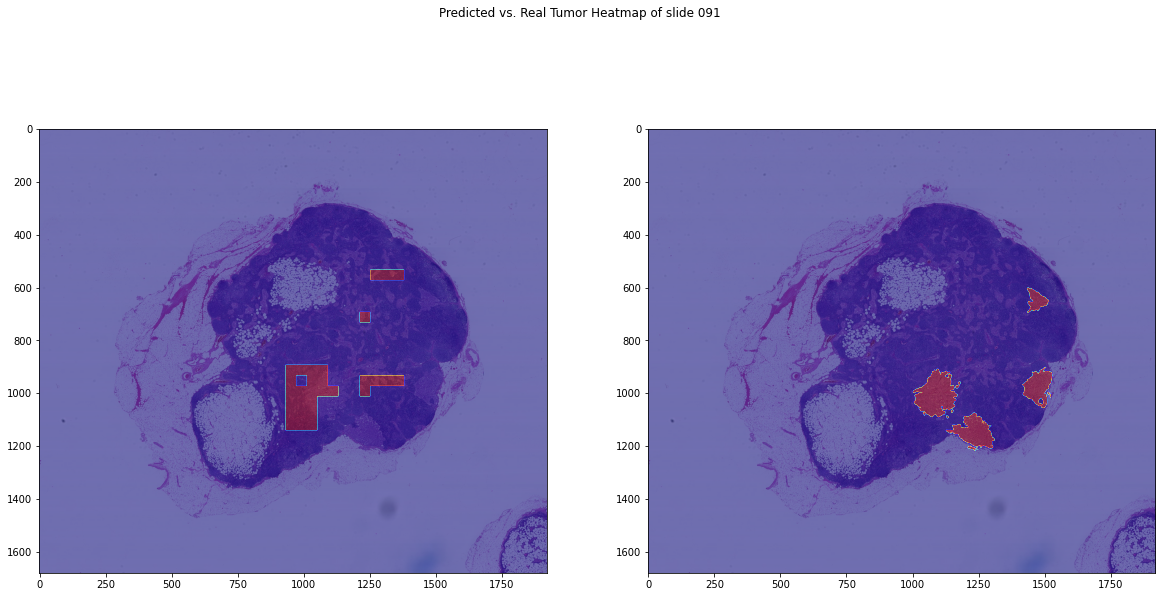


Label heatmap for 075
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_075.tif with width: 2816, height: 2464
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_075_mask.tif with width: 2816, height: 2464
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_075.tif with width: 1408, height: 1232
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_075_mask.tif with width: 1408, height: 1232
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_075.tif with width: 704, height: 616
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_075_mask.tif with width: 704, height: 616
The shape of predict_mask (2464, 2816)
The number of tumor of predict_mask 0.0
1.0 [[0.06912059]]
1.0 [[0.04670192]]
1.0 [[0.05323699]]
1.0 [[0.03408968]]
1.0 [[0.00849203]]
1.0 [[0.17857711]]
1.0 [[0.108

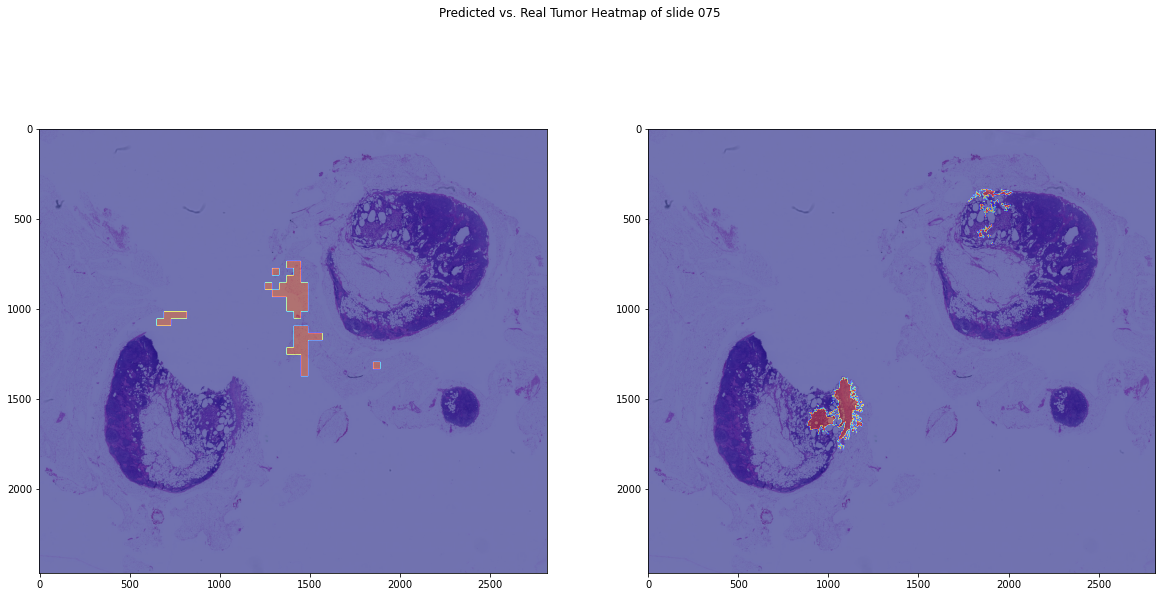


Label heatmap for 094
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_094.tif with width: 3712, height: 3136
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_094_mask.tif with width: 3712, height: 3136
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_094.tif with width: 1856, height: 1568
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_094_mask.tif with width: 1856, height: 1568
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_094.tif with width: 928, height: 784
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_094_mask.tif with width: 928, height: 784
The shape of predict_mask (3136, 3712)
The number of tumor of predict_mask 0.0
1.0 [[0.86940175]]
1.0 [[0.9359624]]
1.0 [[0.89386356]]
1.0 [[0.96065164]]
1.0 [[0.7970807]]
1.0 [[0.565906]]
1.0 [[0.8804046

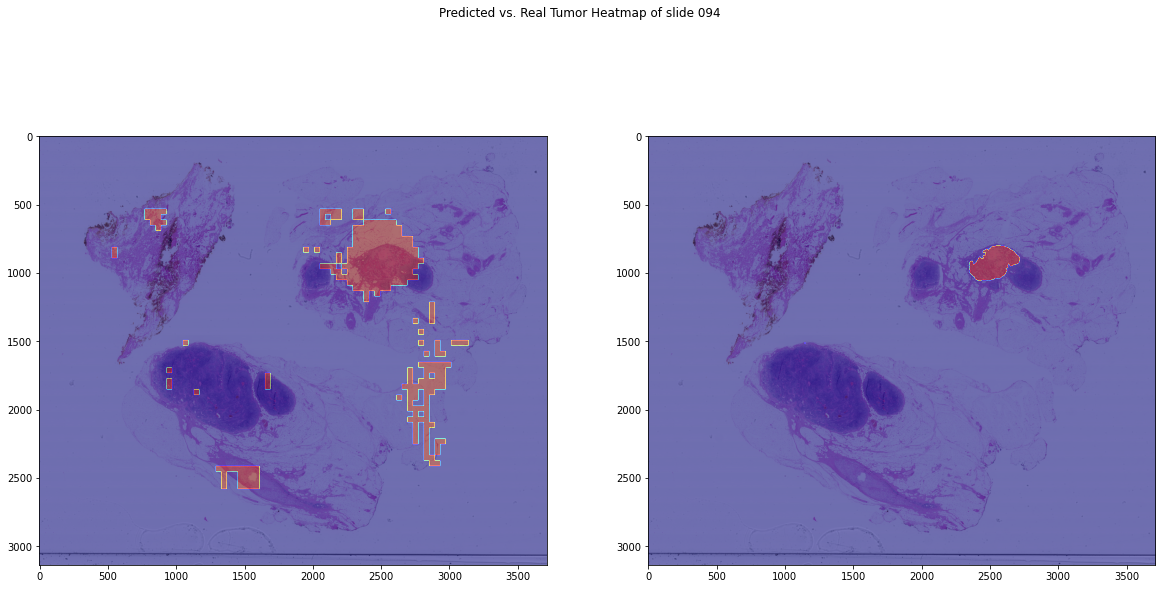


Label heatmap for 084
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_084.tif with width: 2048, height: 2688
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_084_mask.tif with width: 2048, height: 2688
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_084.tif with width: 1024, height: 1344
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_084_mask.tif with width: 1024, height: 1344
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_084.tif with width: 512, height: 672
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_084_mask.tif with width: 512, height: 672
The shape of predict_mask (2688, 2048)
The number of tumor of predict_mask 0.0
1.0 [[0.06728075]]
1.0 [[0.01398723]]
1.0 [[0.02674983]]
1.0 [[0.03040144]]
1.0 [[0.01341596]]
1.0 [[0.02724056]]
1.0 [[0.047

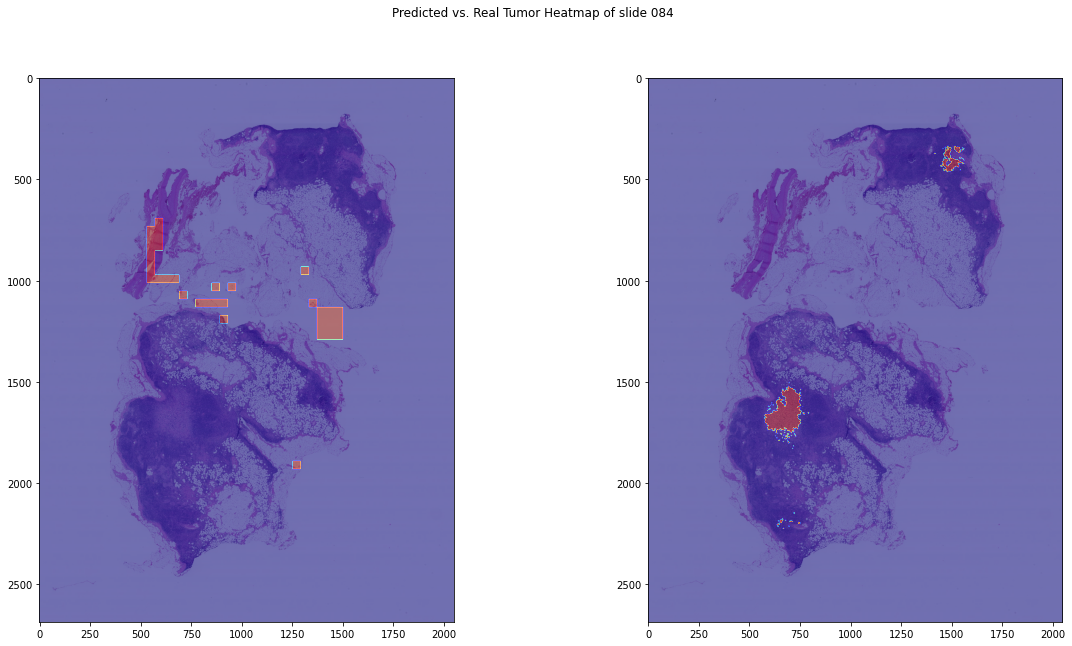

In [ ]:
for slide_num in test_file:
  print("\nLabel heatmap for", slide_num)
  
  level_lst = [5,6,7]
  multi_slide_images = []
  multi_mask_images = []
  for level in level_lst:
    slide_image = read_full_image(slide_num, level=level, ifmask=False)
    mask_image = read_full_image(slide_num, level=level, ifmask=True)
    multi_slide_images.append(slide_image)
    multi_mask_images.append(mask_image)

  predict_mask = np.zeros(multi_mask_images[0].shape, dtype=float)
  print("The shape of predict_mask", predict_mask.shape)
  print("The number of tumor of predict_mask", predict_mask.sum())

  predict_mask = label_heatmap_multizooms(
      multi_slide_images, multi_mask_images, predict_mask, 
      threshold=0.5, step=10, pred_level=5, patch_len=299, 
      show_res=True, verbose=0)
  print("The number of tumor of predict_mask after labeling", predict_mask.sum())
  
  f, axarr = plt.subplots(1,2) 
  f.set_figheight(10)
  f.set_figwidth(20)
  f.suptitle(f'Predicted vs. Real Tumor Heatmap of slide {slide_num}')
  axarr[0].imshow(multi_slide_images[0])
  axarr[0].imshow(predict_mask, cmap='jet', alpha=0.5)
  axarr[1].imshow(multi_slide_images[0])
  axarr[1].imshow(multi_mask_images[0], cmap='jet', alpha=0.5)
  plt.show()

In [ ]:
slide_num = "091"
level_lst = [5,6,7]

multi_slide_images = []
multi_mask_images = []
for level in level_lst:
  slide_image = read_full_image(slide_num, level=level, ifmask=False)
  mask_image = read_full_image(slide_num, level=level, ifmask=True)
  multi_slide_images.append(slide_image)
  multi_mask_images.append(mask_image)

predict_mask = np.zeros(multi_mask_images[0].shape, dtype=float)
print(predict_mask.shape)
print(predict_mask.sum())

Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091.tif with width: 1920, height: 1680
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091_mask.tif with width: 1920, height: 1680
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091.tif with width: 960, height: 840
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091_mask.tif with width: 960, height: 840
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091.tif with width: 480, height: 420
Read WSI from /content/drive/MyDrive/Colab Notebooks/ADL/project/raw_data/Copy of tumor_091_mask.tif with width: 480, height: 420
(1680, 1920)
0.0


In [ ]:
# pred_level = 5
# patch_len = 299

# x_scan = 0

# while x_scan <= multi_slide_images[-1].shape[0] - patch_len:
  
#   y_scan = 0
  
#   while y_scan <= multi_slide_images[-1].shape[1] - patch_len:
    
#     xc_0, yc_0 = get_center(slide_image, x_scan, y_scan, level=level)
    
#     factor = 2 ** pred_level
#     xc_level = xc_0 // factor
#     yc_level = yc_0 // factor
#     x_level = xc_level - patch_len//2
#     y_level = yc_level - patch_len//2
#     assert 0 <= x_level + patch_len-1 <= multi_slide_images[0].shape[0]
#     assert 0 <= y_level + patch_len-1 <= multi_slide_images[0].shape[1]
#     assert 0 <= x_level <= multi_slide_images[0].shape[0]
#     assert 0 <= y_level <= multi_slide_images[0].shape[1]

#     multi_tumor_regions = get_patches_from_center(multi_slide_images, xc_0, yc_0, level_lst=level_lst)
    
#     if delete_gray(multi_tumor_regions[0]):

#       multi_check_images = get_patches_from_center(multi_mask_images, xc_0, yc_0, level_lst=level_lst)
#       label = get_target(multi_check_images[0])

#       multi_tumor_regions = [region / 255.0 for region in multi_tumor_regions]

#       input_data = {
#           "input1": np.array([multi_tumor_regions[0]]), 
#           "input2": np.array([multi_tumor_regions[1]]),
#           "input3": np.array([multi_tumor_regions[2]])
#           }
#       pred = model.predict(input_data)

#       pred_label = (pred > 0.5).astype("int32")

#       if label == 1:
#         print(label, pred)

#       if pred_label[0][0] == 1:
#         predict_mask = label_prediction(x_level, y_level, predict_mask, label=1)

#       else:
#         predict_mask = label_prediction(x_level, y_level, predict_mask, label=0)

#     y_scan += 10

#   x_scan += 10


1/1 [==============================] - 0s 59ms/step
1.0 [[0.3230591]]
1/1 [==============================] - 0s 54ms/step
1.0 [[0.3230591]]
1/1 [==============================] - 0s 55ms/step
1.0 [[0.3230591]]
1/1 [==============================] - 0s 70ms/step
1.0 [[0.3230591]]
1/1 [==============================] - 0s 46ms/step
1.0 [[0.3230591]]
1/1 [==============================] - 0s 52ms/step
1.0 [[0.3230591]]
1/1 [==============================] - 0s 58ms/step
1.0 [[0.3230591]]
1/1 [==============================] - 0s 50ms/step
1.0 [[0.3230591]]
1/1 [==============================] - 0s 44ms/step
1.0 [[0.3230591]]
1/1 [==============================] - 0s 44ms/step
1.0 [[0.3230591]]
1/1 [==============================] - 0s 45ms/step
1.0 [[0.3230591]]
1/1 [==============================] - 0s 45ms/step
1.0 [[0.3230591]]
1/1 [==============================] - 0s 49ms/step
1.0 [[0.3230591]]
1/1 [==============================] - 0s 44ms/step
1.0 [[0.3230591]]
1/1 [===============

In [ ]:
predict_mask.sum()

49664.0

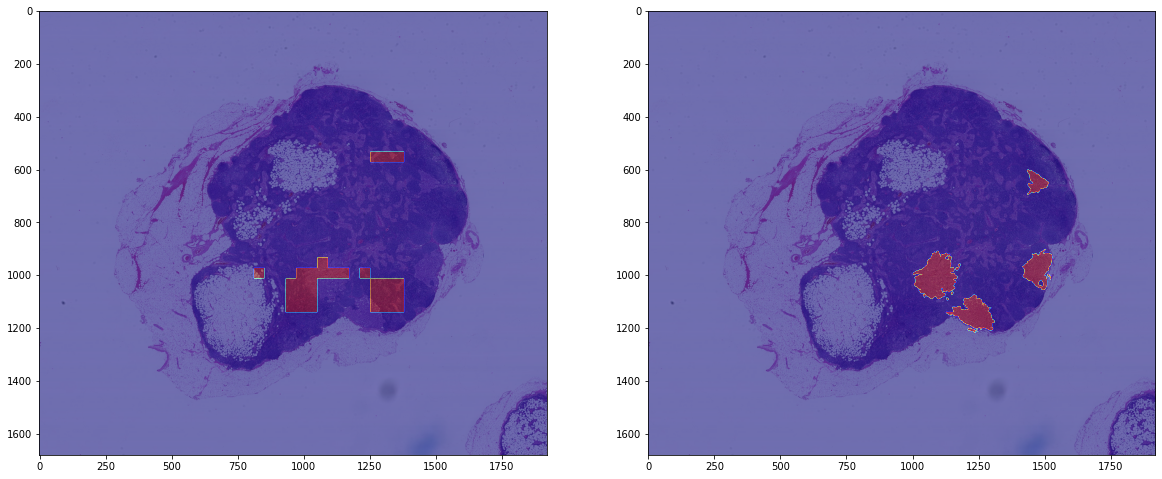

In [ ]:
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,2) 
f.set_figheight(10)
f.set_figwidth(20)

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(multi_slide_images[0])
axarr[0].imshow(predict_mask, cmap='jet', alpha=0.5)

axarr[1].imshow(multi_slide_images[0])
axarr[1].imshow(multi_mask_images[0], cmap='jet', alpha=0.5)

<Figure size 432x288 with 0 Axes>

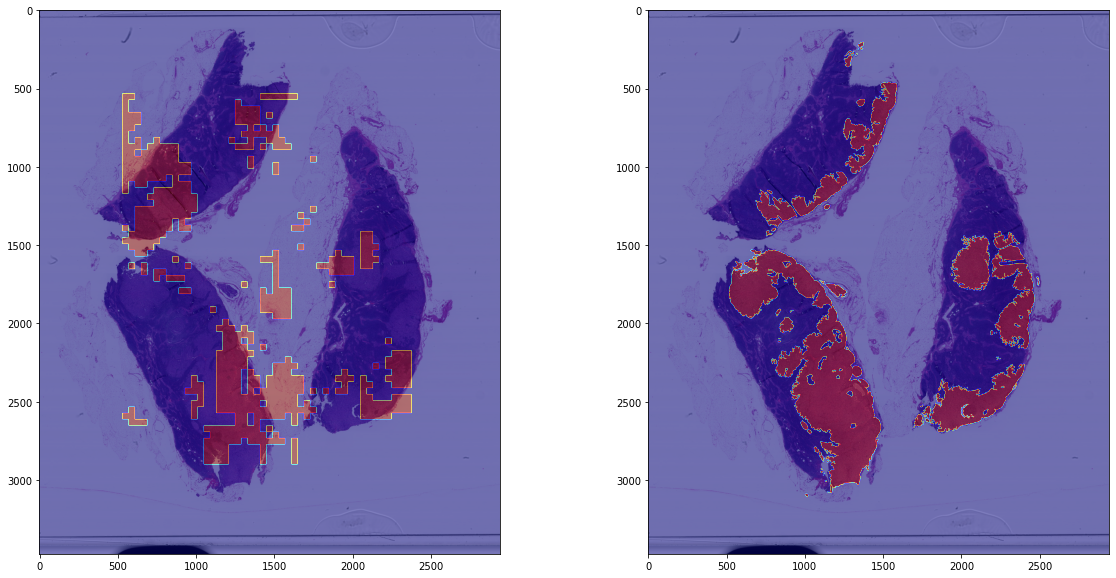

In [ ]:
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,2) 
f.set_figheight(10)
f.set_figwidth(20)

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(multi_slide_images[0])
axarr[0].imshow(predict_mask, cmap='jet', alpha=0.5)

axarr[1].imshow(multi_slide_images[0])
axarr[1].imshow(multi_mask_images[0], cmap='jet', alpha=0.5)